# Machine Failure Classification

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Models 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from xgboost import XGBClassifier

# Data Processing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV

# Model Processing
from sklearn.dummy import DummyClassifier
from sklearn.metrics import make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, StandardScaler
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from sklearn.decomposition import PCA

# K Best columns
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif


from keras.optimizers import SGD, Adam, RMSprop
from keras.regularizers import l2, l1
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Functions

In [2]:
def check_class_imbalance(df:pd.DataFrame, target:pd.Series, col:str):
  counter = Counter(target)
  for k,v in counter.items():
    per = v/len(target) * 100
    print("Class=%s, Count=%d, Percentage=%.3f%%" % (k,v, per))
  
  ax = df[col].value_counts().sort_index().plot(
  kind="bar", 
  title="Count of Reviews by Target", 
  figsize=(10,5)
  )
  ax.set_xlabel(col)
  plt.show()
  
    
def evaluate_model(X, y, model):
  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
  
  metric = make_scorer(f1_score)
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores


def testing_selected_models(names:list, models:list, X:pd.DataFrame, y:pd.Series):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    model_performance = []
    for i in range(len(models)):
        model = models[i]
        pipeline = Pipeline(steps=[('scaler', StandardScaler()), ("power_tranformer",PowerTransformer()), ('model', model)])
        scores = evaluate_model(X, y, pipeline)
        model_performance.append({
            "Model": names[i],
            "Mean": np.mean(scores),
            "STD":np.std(scores)
        })
    performance_df = pd.DataFrame(model_performance)
    return performance_df.sort_values(by="Mean", ascending=False)
def get_selected_models(names):
  """
  Returns selected models for ML processing

  Args:
      names (_type_):List

  Returns:
      List of models
  """
  models = {
    "LDA": LinearDiscriminantAnalysis(),
    "GPC": GaussianProcessClassifier(),
    "GNB": GaussianNB(),
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier(),
    "MN": MultinomialNB()
  }
  
  return [models[model] for model in names]


# EDA Analysis

In [5]:
df = pd.read_csv("/Users/maukanmir/Downloads/machine_failure_cleaned.csv")
df

,Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,Machine failure
0,1551,42.8,0,0,0,0,0,0
1,1408,46.3,3,0,0,0,0,0
2,1498,49.4,5,0,0,0,0,0
3,1433,39.5,7,0,0,0,0,0
4,1408,40.0,9,0,0,0,0,0
...,...,...,...,...,...,...,...,...
9810,1604,29.5,14,0,0,0,0,0
9811,1632,31.8,17,0,0,0,0,0
9812,1645,33.4,22,0,0,0,0,0
9813,1408,48.5,25,0,0,0,0,0


# Check For Nulls and Dupes

In [6]:
print(f"Null Count: {df.isna().sum()}")
print(f"Dupe Count: {df.duplicated().sum()}")

Null Count: Rotational speed [rpm]    0
Torque [Nm]               0
Tool wear [min]           0
TWF                       0
HDF                       0
PWF                       0
OSF                       0
Machine failure           0
dtype: int64
Dupe Count: 6


In [7]:
df.drop_duplicates(inplace=True)

# Check Class Imbalance

Class=0, Count=9523, Percentage=97.084%
Class=1, Count=286, Percentage=2.916%


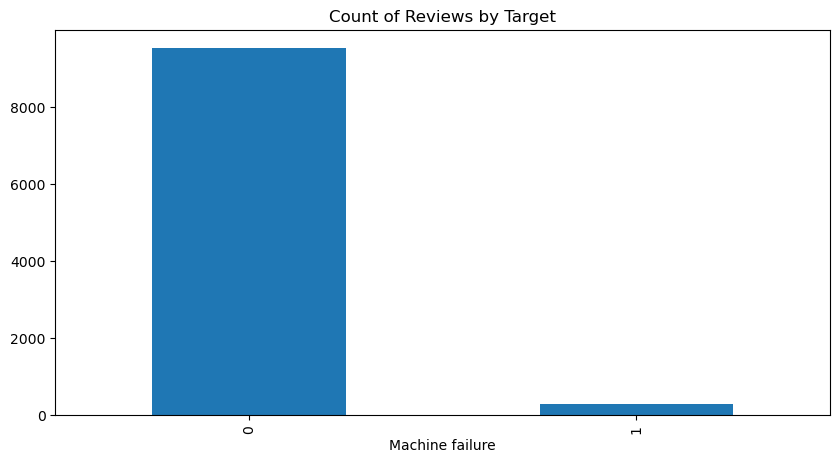

In [8]:
check_class_imbalance(df,df['Machine failure'], 'Machine failure')

# Extreme Class Imbalance which will have to be addressed through sampling methods

In [9]:
df.dtypes

Rotational speed [rpm]      int64
Torque [Nm]               float64
Tool wear [min]             int64
TWF                         int64
HDF                         int64
PWF                         int64
OSF                         int64
Machine failure             int64
dtype: object

In [10]:
df.describe()

,Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,Machine failure
count,9809.000000,9809.000000,9809.000000,9809.000000,9809.000000,9809.000000,9809.000000,9809.000000
mean,1526.408095,40.329728,107.926802,0.004486,0.011724,0.004486,0.009583,0.029157
std,147.339453,9.422408,63.605989,0.066828,0.107646,0.066828,0.097428,0.168255
min,1168.000000,16.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1422.000000,33.600000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1501.000000,40.200000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1606.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2076.000000,68.900000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000
